Cropping and Rotating

In [1]:
def crop_rotate_dir(input_dir = 'input',output_dir='output', angle = -1.5, left = 135, upper =85, right = 600, lower = 390):
    from PIL import Image
    import os, glob
    # read every image file from the input folder
    for filename in glob.glob(input_dir+'/*.jpg'):
        # print(filename)
        with Image.open(filename) as im:
            # (left, upper, right, lower) = (100, 60, 630, 400)
            rotated = im.rotate(angle, expand = 1)
            im_final = rotated.crop((left, upper, right, lower))            
            im_final.save(filename.replace(input_dir, output_dir))

In [3]:
# Best parameters
crop_rotate_dir(input_dir = 'in_test',output_dir='output_test',left = 135, upper =85, right = 600, lower = 390)

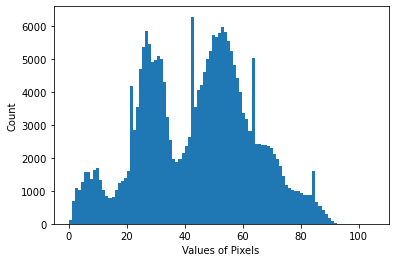

In [2]:
# colmport the necessary libraries
from PIL import Image
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
import numpy as np
import os, glob

# this is a pipeline that allows you to do an operation on each well for each image
def pipeline(input_dir = 'output'):
    import os, glob
    from PIL import Image
    import numpy as np
    from numpy import asarray
    # read every image file from the input folder
    big_output = []
    pred_outputs = []
    for filename in glob.glob(input_dir+'/*.jpg'):
        img = Image.open(filename).convert('L')
        img_numpydata = asarray(img)
        y = img_numpydata.shape[0] / 16
        x = img_numpydata.shape[1] / 24
        output = np.zeros(shape=(16,24))
        pred_output = np.zeros(shape=(16,24))
        rows = 0
        columns = 0
        for col in np.arange(0, img_numpydata.shape[0], y):
            for row in np.arange(0, img_numpydata.shape[1], x):
                out = img_numpydata[round(col):round(col+y),round(row):round(row+x)]
                min = np.amin(out)
                output[rows,columns] = min
                pred_output[rows,columns] = 1 if min < 38 else 0
                columns += 1
            rows += 1
            columns = 0
        np.savetxt(filename.replace(input_dir, 'output_values').replace('.jpg','.txt'), output)
        np.savetxt(filename.replace(input_dir, 'output_pred').replace('.jpg','.txt'), pred_output)
        pred_outputs.append(pred_output)
        big_output.append(output)
    # plot histogram of output
    plt.xlabel('Values of Pixels')
    plt.ylabel('Count')
    plt.hist(asarray(big_output).flatten(), bins=100)

pipeline()
